In [1]:
import cooler
from cooler.util import open_hdf5
import hicona

In [2]:
BIG_FILE_PATH = "test_files/big_full_process.mcool::resolutions/10000"
SMALL_FILE_PATH = "test_files/small.mcool::resolutions/10000"
TEST_CHROM = "chr8"
cool = hicona.HiconaCooler(BIG_FILE_PATH)

In [38]:
cum_sum = 0
for chrom in ["chr10", "chr20"]:
    with open_hdf5(cool.store, mode="r") as h5_handle:
        extent = cool.extent(chrom)
        h5_grp = h5_handle[cool.root]
        min_off = h5_grp["indexes/bin1_offset"][extent[0]]
        max_off = h5_grp["indexes/bin1_offset"][extent[1]]
        df_size = cool.pixels()[min_off:max_off]
        df_gb = sum(df_size.memory_usage(deep=True))
        cum_sum += df_gb
    print(f"{chrom}: {max_off - min_off}, {df_gb}")
cum_sum

chr10: 8119321, 227340988
chr20: 2089040, 58493120


285834108

1 pixel = 28 bytes = 3 single precision numbers (8 bytes) for index, bin1_id, bin2_id, 1 half precision number (4 bytes) for count

35,000,000 pixels $\approx$ 1 Gb

In [1]:
lower, upper = cool.extent(TEST_CHROM)
with open_hdf5(cool.store, mode="r") as h5_handle:
    h5_grp = h5_handle[cool.root]
    lo_pix = h5_grp["indexes/bin1_offset"][lower]
    hi_pix = h5_grp["indexes/bin1_offset"][upper]

stat = "median"
pix_df = cool.pixels()[lo_pix:hi_pix]
pix_df["bin_difference"] = pix_df["bin2_id"] - pix_df["bin1_id"]
indexer = pix_df[pix_df["bin2_id"] >= upper].index
pix_df.drop(indexer, inplace=True)
group_counts = pix_df.groupby("bin_difference")["count"]
decay_curve = group_counts.agg(stat).to_frame()

NameError: name 'cool' is not defined

<Axes: xlabel='bin_difference'>

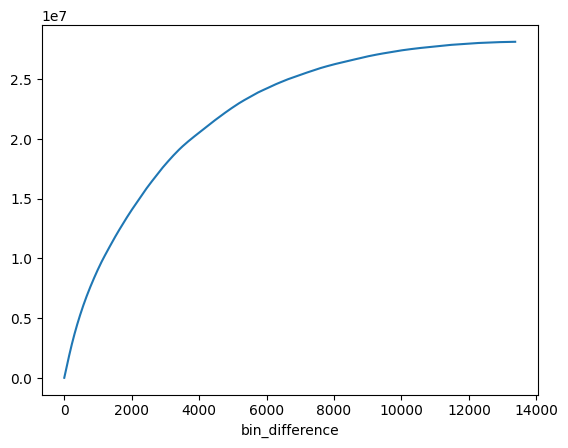

In [7]:
cumulative = group_counts.count().cumsum()
cumulative.plot()
# cumulative.plot(logx=True)

In [5]:
thr_vals = [50, 100, 500, 1000, 2500, 5000, 10000]
tot_pix = pix_df.shape[0]
for val in thr_vals:
    print(f"{val}: abs {cumulative[val]}, % {cumulative[val]/tot_pix*100}")

50: abs 664399, % 2.3611278731067413
100: abs 1307873, % 4.647892899874523
500: abs 5528909, % 19.64852618346915
1000: abs 9094110, % 32.318466165811124
2500: abs 16095934, % 57.20140820664463
5000: abs 22651570, % 80.49869626027201
10000: abs 27420050, % 97.44482507797349


Roughly using 100, 500, 1000, 2500, 5000 as cutoffs might work